<a href="https://colab.research.google.com/github/Fyfy1996/Natural_language_understanding/blob/master/Lab_4_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-lingual embeddings

In this lab we will explore multilingual word embeddings and build a very rudimentary translation system.

Adapted from: https://github.com/facebookresearch/MUSE/blob/master/demo.ipynb

## Theory
Cross-lingual embedding vectors can be trained in supervised or unsupervised way.   

**Supervised.**  

First, the embeddings are trained for each language separately.   
Then optimization problem of aligning the embeddings is solved using a seed lexicon (small number of aligned pairs of words) by minimizing square loss with cross-domain similarity local scaling (CSLS) criterion.  
More details in [Joulin et al (2018)](https://arxiv.org/pdf/1804.07745.pdf)

**Unsupervised.**

First, a rotation matrix $W$ which roughly aligns the
two distributions is learnt using adversarial learning.   
Second, the mapping $W$ is further refined: frequent words aligned by the previous step are used as anchor points, and an energy function that corresponds to a spring system between anchor points is minimized (Procrustes method).   
Finally, they translate by using the mapping $W$ and a distance metric (CSLS) that expands the space where there is high density of points (like the area around the word
“cat”), so that “hubs” (like the word “cat”) become less close to other word vectors than they would otherwise.

![](https://drive.google.com/uc?export=view&id=1IuI4NGiUMUtS5whr_mldnsL5tFVoKtwH)


More details in [Conneau et al (2018)](https://arxiv.org/pdf/1710.04087.pdf)

## Practice

### Load embeddings
Here we load a subset of 100,000 + 100,000 aligned [fastText embeddings](https://fasttext.cc/docs/en/aligned-vectors.html) for English and Russian languages. 

In [0]:
!wget 'https://drive.google.com/uc?export=download&id=1-Hrc2uz14kmcsKYle7_penmpR7t0TtZR' -O en_embeddings.npz
!wget 'https://drive.google.com/uc?export=download&id=1-ZnGxODZypEnz5E0ssXLCEMG-fSfU28W' -O en_word2id.p

!wget 'https://drive.google.com/uc?export=download&id=1-OE9Tw8M5jWvM-4WRKfladaQzLIgoxiT' -O ru_embeddings.npz
!wget 'https://drive.google.com/uc?export=download&id=1-Y42yEnIsrQtVdQ7PABrvrn4eYRKmyuG' -O ru_word2id.p

!wget 'https://drive.google.com/uc?export=download&id=1-TsynEry2jdbIY2P3_c7UjHdbwr345Nf' -O secret_embeddings.npy

--2020-02-20 17:39:11--  https://drive.google.com/uc?export=download&id=1-Hrc2uz14kmcsKYle7_penmpR7t0TtZR
Resolving drive.google.com (drive.google.com)... 172.217.193.101, 172.217.193.102, 172.217.193.138, ...
Connecting to drive.google.com (drive.google.com)|172.217.193.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a43j5bf0tkpuf4lpsvmqg92jj0g4dd8k/1582219800000/08752484438609855375/*/1-Hrc2uz14kmcsKYle7_penmpR7t0TtZR?e=download [following]
--2020-02-20 17:39:13--  https://doc-08-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a43j5bf0tkpuf4lpsvmqg92jj0g4dd8k/1582219800000/08752484438609855375/*/1-Hrc2uz14kmcsKYle7_penmpR7t0TtZR?e=download
Resolving doc-08-04-docs.googleusercontent.com (doc-08-04-docs.googleusercontent.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to doc-08-04-docs.googleusercontent.com (do

In [0]:
import numpy as np
import pickle
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
# load the files
x = np.load('en_embeddings.npz', allow_pickle=True)
en_embeddings = [x[k] for k in x][0]

x = np.load('ru_embeddings.npz', allow_pickle=True)
ru_embeddings = [x[k] for k in x][0]

with open('en_word2id.p', 'rb') as handle:
    en_word2id = pickle.load(handle)

with open('ru_word2id.p', 'rb') as handle:
    ru_word2id = pickle.load(handle)

# create id2word for both languages
en_id2word = [None] * len(en_word2id)
for word, idx in en_word2id.items():
    en_id2word[idx] = word
ru_id2word = [None] * len(ru_word2id)
for word, idx in ru_word2id.items():
    ru_id2word[idx] = word

### Visualize multilingual embeddings

Let's visualize the embeddings. We take pairs of words that have same meaning, where one is English and the other is Russian. As they exist in 300-dimensional space which is hard to imagine, we need to project them to a 2D space. We will use the first two components of PCA to do this. 

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
pca.fit(np.vstack([en_embeddings, ru_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.15


In [0]:
import matplotlib.pyplot as plt

def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find PCA coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')
        
    for k in range(len(src_words)):
        idx_src = k
        idx_tgt = k + len(src_words)
        plt.plot([x_coords[idx_src], x_coords[idx_tgt]], [y_coords[idx_src], y_coords[idx_tgt]])

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

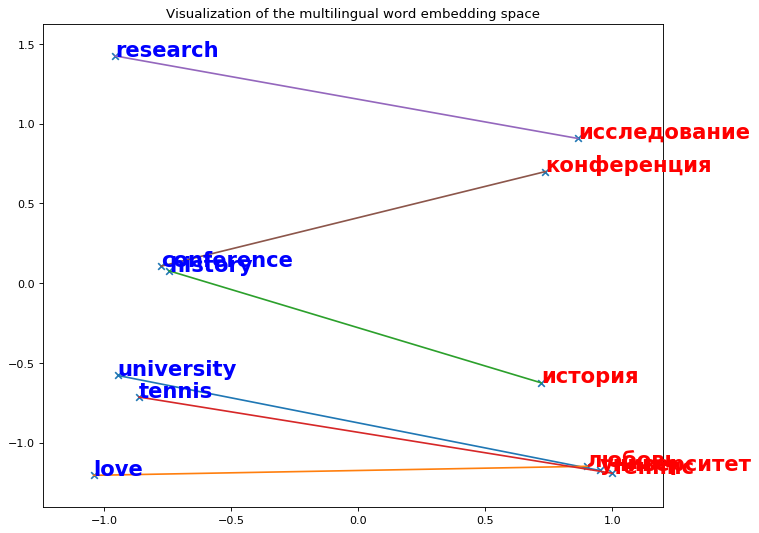

In [0]:
# get 5 random input words
en_words = ['university', 'love', 'history', 'tennis', 'research', 'conference']
ru_words = ['университет', 'любовь', 'история', 'теннис', 'исследование', 'конференция']

# assert words in dictionaries
for en_word in en_words:
    assert en_word in en_word2id, '"%s" not in source dictionary' % en_word
for ru_word in ru_words:
    assert ru_word in ru_word2id, '"%s" not in target dictionary' % ru_word

plot_similar_word(en_words, en_word2id, en_embeddings, ru_words, ru_word2id, ru_embeddings, pca)

### Get nearest neigbors for a given word

Let's write a function that given a word, returns its K nearest neighbors in the vector space.

In [0]:
def get_nn(word, src_emb, src_word2id, tgt_emb, tgt_id2word, K=5):
    """
    Input:
    ------
    - word: str
        Word for which we want to get its nearest neighbors
    - src_emb: np.array
        Matrix of embeddings of source language (the language from which the word comes)
        of shape (number of words in src language, embedding size)
    - src_id2word: dict
        Dictionary that maps index to word for source language
    - tgt_emb: np.array
        Matrix of embeddings of target language (the language in which we want to find closest words)
        of shape (number of words in tgt language, embedding size)
    - tgt_id2word: dict
        Dictionary that maps index to word for target language
    - K: int
        Number of nearest neighbors to output

    Output:
    -------
    - k_best: dict
        Dictionary in which key is a word and value is its distance score (cosine similarity)
    """
    # Your code goes here

    # 1. Look up the word embedding
    idx = src_word2id[word]
    # raise NotImplementedError

    # 2. Compute the scores for each word
    word_emd = src_emb[idx]
    scores = tgt_emb.dot(word_emd)

    # for i in range(src_emb.shape[0]):
    #   scores.append( cosine_similarity(str_vec, src_emb[i,:]))
    

    # 3. Find the index of the top K best scoring words
   
    # 4. Get the corresponding top K words
    k_best = pd.Series(scores, index=tgt_id2word).sort_values(ascending = False)[:K]



    return k_best

def print_k_best_for_word(k_best, word):
    print("Nearest neighbors of \"%s\":" % word)
    for word, score in k_best.items():
        print('%.4f - %s' % (score, word))

    print()

In [0]:
en_words = ["algorithm", "language", "research"]
for word in en_words:
    k_best = get_nn(word, en_embeddings, en_word2id, en_embeddings, en_id2word, K=6)
    print_k_best_for_word(k_best, word)

Nearest neighbors of "algorithm":
0.9999 - algorithm
0.8939 - algorithms
0.7575 - heuristic
0.7427 - recursive
0.7425 - computation
0.7377 - polynomial

Nearest neighbors of "language":
0.9999 - language
0.8152 - languages
0.6772 - linguistic
0.6699 - spoken
0.6548 - bilingual
0.6486 - multilingual

Nearest neighbors of "research":
1.0000 - research
0.7609 - researches
0.7181 - researcher
0.7034 - researchers
0.6741 - biomedical
0.6498 - laboratory



In [0]:
en_words = ["hello", "world"]
for word in en_words:
    k_best = get_nn(word, en_embeddings, en_word2id, en_embeddings, en_id2word, K=3)
    print_k_best_for_word(k_best, word)

Nearest neighbors of "hello":
1.0000 - hello
0.6525 - teahouse
0.6231 - hey

Nearest neighbors of "world":
1.0000 - world
0.6058 - worlds
0.5053 - war



We can also search in Russian and find the closest words in English!

In [0]:
ru_words = ["привет", "мир"]
for word in ru_words:
    k_best = get_nn(word, ru_embeddings, ru_word2id, en_embeddings, en_id2word, K=3)
    print_k_best_for_word(k_best, word)

Nearest neighbors of "привет":
0.3853 - greetings
0.3677 - hello
0.3537 - dear

Nearest neighbors of "мир":
0.3341 - peace
0.3282 - world
0.2986 - worlds



### A simple word-to-word translation system

We can try to use aligned embeddings to build a very rudimentary translation system.

Here is a list of texts in Russian. We will parse it, convert to lowercase, remove all special symbols, and split to words.   
Then for each word, if it exists in `ru_word2id`, translate it to english (using closest english word), otherwise skip it.

In [0]:
ru_texts = [
"""Игровое действие в американском футболе состоит из серии коротких по продолжительности отдельных схваток, за пределами которых мяч называют «мертвым» или не в игре. Во время схватки могут быть разыграны:
пасовая комбинация,
выносная комбинация,
пант (удар по мячу),
попытка взятия зачетной зоны
свободный удар (ввод мяча в игру – начальный удар)
Цель игры – набрать максимальное количество очков, занеся мяч в зачетную зону противника (тачдаун - touchdown) или забив его в ворота с поля (филд-гол – field goals). Побеждает команда, набравшая наибольшее количество очков.""",
"""Я вас любил: любовь ещё, быть может,
В душе моей угасла не совсем;
Но пусть она вас больше не тревожит;
Я не хочу печалить вас ничем.
Я вас любил безмолвно, безнадежно,
То робостью, то ревностью томим;
Я вас любил так искренно, так нежно,
Как дай вам Бог любимой быть другим""",
"""Сегодня мы говорим про слова и стоит обсудить, как делать такое сопоставление вектора слову.
Вернемся к предмету: вот у нас есть слова и есть компьютер, который должен с этими словами как-то работать. Вопрос — как компьютер будет работать со словами? Ведь компьютер не умеет читать, и вообще устроен сильно иначе, чем человек. Самая первая идея, приходящая в голову — просто закодировать слова цифрами по порядку следования в словаре.""",
"""Интернет-мем — информация в той или иной форме (медиаобъект, то есть объект, создаваемый электронными средствами коммуникации, фраза, концепция или занятие), как правило, остроумная и ироническая[2], спонтанно приобретающая популярность, распространяясь в Интернете разнообразными способами (посредством социальных сетей, форумов, блогов, мессенджеров и пр.). Обозначает также явление спонтанного распространения такой информации или фразы. 
Мемами могут считаться как слова, так и изображения. Иначе говоря, это любые высказывания, картинки, видео или звукоряд, которые имеют значение и устойчиво распространяются во Всемирной паутине.""",
]

In [0]:
import re

for ru_text in ru_texts:
    ru_text = re.sub(',(?!\s+\d$)', '', ru_text).lower()
    translation = []

    for word in re.split(r'(\s+)', ru_text):
        # Your code goes here
        if word.isspace():
          candidate = word
        elif word in ru_word2id:
          k_best = get_nn(word, ru_embeddings, ru_word2id, en_embeddings, en_id2word, K=1)
          candidate = list(k_best.index)[0]
        else:
          candidate = word
        # candidate = ru_embeddings[ru_word2id[word]]
        # candidate = str(get_nn(word, ru_embeddings, ru_word2id, en_embeddings, en_id2word, K=1))

        translation.append(candidate)

    print("".join(translation))
    print("\n===\n")

игровое action in usa footballing consists from series short by duration individual схваток for outside which ball referred «мертвым» or but in игре. during during fights can be разыграны:
пасовая combination
выносная combination
пант (удар by мячу)
attempt capture зачетной zones
free blow (ввод goalkeeper in game – initial удар)
aim games – gain maximum number points занеся ball in зачетную zone enemy (тачдаун - touchdown) or scored his in gate with fields (филд-гол – field goals). defeats team набравшая fewest number очков.

===

i you любил: love one be can
in passion my угасла but совсем;
but let she you than but тревожит;
i but want печалить you ничем.
i you loved безмолвно безнадежно
so робостью so ревностью томим;
i you loved that искренно that нежно
as dang you god favorite be direct

===

today we talking like phrases and stands discuss as make that сопоставление vector слову.
вернемся towards предмету: just there we there phrases and there computer which must with between fai

### Bonus: Find the missing words!

We secretly removed four English words from the English embedding data! However, we saved their embedding vectors. Can you recover the missing words?

*Hint: Find the nearest neighbors for each vector.*

*Hint: You can test if your guesses are correct be seeing if the word exists in the `en_word2id` dictionary.*

Once you have found them, you can DM me (Jason) on Campuswire with the missing words. Remember to include your NetID.

In [0]:
file_name = "secret_embeddings.npy"
secret_embeddings = np.load(file_name, allow_pickle=True)
secret_embeddings.shape

(4, 300)

In [0]:
# Your code goes here
for i in range(secret_embeddings.shape[0]):
  scores = en_embeddings.dot(secret_embeddings[i,:])
  k_best = pd.Series(scores, index = en_id2word).sort_values(ascending = False)[:10]
  print(k_best)


blackberry    0.670222
macintosh     0.646194
iphone        0.626495
ipod          0.605988
ipad          0.599306
raspberry     0.597980
ios           0.568360
pear          0.542598
acorn         0.540900
microsoft     0.540322
dtype: float64
locate           0.720344
searching        0.716868
discover         0.671671
prove            0.640013
searched         0.634485
searches         0.632548
looking          0.616509
get              0.612974
realize          0.604796
unfortunately    0.598889
dtype: float64
birth            0.510727
dead             0.509661
geocoordinate    0.504074
incomplete       0.454087
lacking          0.440699
unknown          0.438655
disappearance    0.438048
living           0.436007
wrong            0.431198
malformed        0.411875
dtype: float64
phrase         0.757281
meaning        0.754418
noun           0.667916
adjective      0.654358
meanings       0.653116
etymology      0.643655
colloquial     0.630563
connotation    0.628555
means        

In [0]:
# Your code goes here
for i in range(secret_embeddings.shape[0]):
  scores = ru_embeddings.dot(secret_embeddings[i,:])
  k_best = pd.Series(scores, index = ru_id2word).sort_values(ascending = False)[:5]
  print(k_best)

apple        0.370538
microsoft    0.251823
iphone       0.250002
яблоко       0.243179
виноград     0.237132
dtype: float64
найти        0.476997
отыскать     0.406743
поискать     0.406523
искать       0.370879
подобрать    0.337052
dtype: float64
осталось    0.241370
пропали     0.230722
проверил    0.223570
ошибка      0.215754
потеря      0.214012
dtype: float64
слово             0.453238
слова             0.391245
словосочетания    0.375588
словосочетание    0.373812
прилагательное    0.358900
dtype: float64


In [0]:
"apple" in en_id2word

False

In [0]:
"find" in en_id2word

False

In [0]:
"deathly" in en_id2word

False

In [0]:
"word" in en_id2word

False